# Bias-Variance Diagnosis with Learning Curve

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

In [42]:
data = pd.read_csv("housing (1).csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Split the data

In [3]:
X = data.drop("median_house_value",axis = 1)
y = data['median_house_value']
X.shape, y.shape

((20640, 9), (20640,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16512, 9), (4128, 9), (16512,), (4128,))

## Preprocessing pipelines

In [5]:
data_num = X_train.select_dtypes([np.number]).columns

data_cat = X_train.select_dtypes(['object']).columns

data_num, data_cat

(Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income'],
       dtype='object'),
 Index(['ocean_proximity'], dtype='object'))

In [6]:
num_impute = SimpleImputer(strategy='median')
num_scaler = StandardScaler()

cat_impute = SimpleImputer(strategy='most_frequent')
cat_encode = OneHotEncoder(handle_unknown='ignore')

In [7]:
num_pipeline = Pipeline(steps=[
    ('num_impute', num_impute),
    ('num_scaler', num_scaler)
])

cat_pipeline = Pipeline(steps = [
    ('cat_impute',cat_impute),
    ('cat_encode', cat_encode)
])

In [8]:
preprocessor = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, data_num),
    ('cat_pipeline', cat_pipeline, data_cat)
])

## Models

In [9]:
lin_model = LinearRegression()

dec_tree_shallow = DecisionTreeRegressor(max_depth=3, random_state=42)

dec_tree_deep = DecisionTreeRegressor(max_depth=None, random_state=42)

## Full Pipelines

In [10]:
lin_reg = Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('lin_model', lin_model)
])

tree_dec_shallow = Pipeline([
    ('preprocessor', preprocessor),
    ('dec_tree_shallow', dec_tree_shallow ),
])

tree_dec_deep = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('dec_tree_deep', dec_tree_deep)
])

## Fit the models

In [11]:
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['ocean_proximity'], dtype='object'))])),
                ('lin_model', LinearRegression())])

In [12]:
tree_dec_shallow.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['ocean_proximity'], dtype='object'))])),
                ('dec_tree_shallow',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

In [13]:
tree_dec_deep.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['ocean_proximity'], dtype='object'))])),
                ('dec_tree_deep', DecisionTreeRegressor(random_state=42))])

In [46]:
def plot_learning_curve(X_train, y_train, pipeline, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )
    # Convert negatives scores to positive RMSE
    train_rmse = -train_scores.mean(axis =1)
    val_rmse =  -val_scores.mean(axis=1)

    # Plot 
    plt.figure(figsize=(10,7))
    plt.plot(train_sizes, train_rmse, "o-", label = "Training RMSE")
    plt.plot(train_sizes, val_rmse, "o-", label = "CV RMSE")

    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve for  - {model_name}")
    plt.legend()
    plt.grid(True);

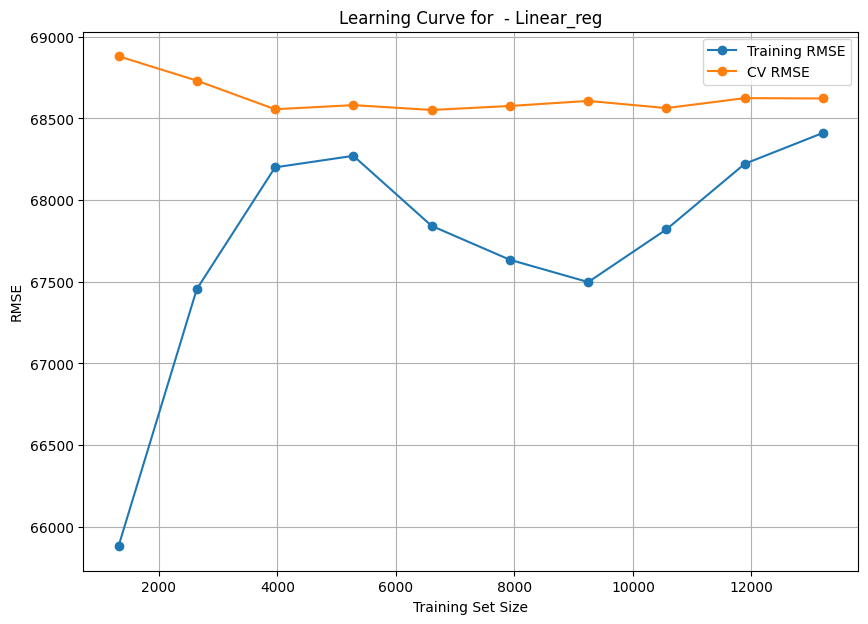

In [50]:
plot_learning_curve(X_train, y_train, lin_reg, 'Linear_reg')

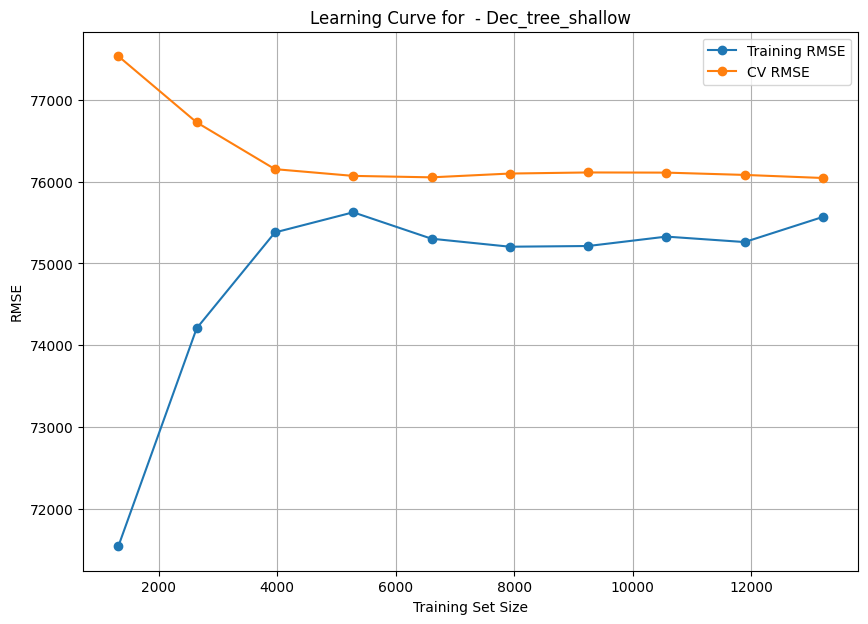

In [48]:
plot_learning_curve(X_train, y_train, tree_dec_shallow, 'Dec_tree_shallow')

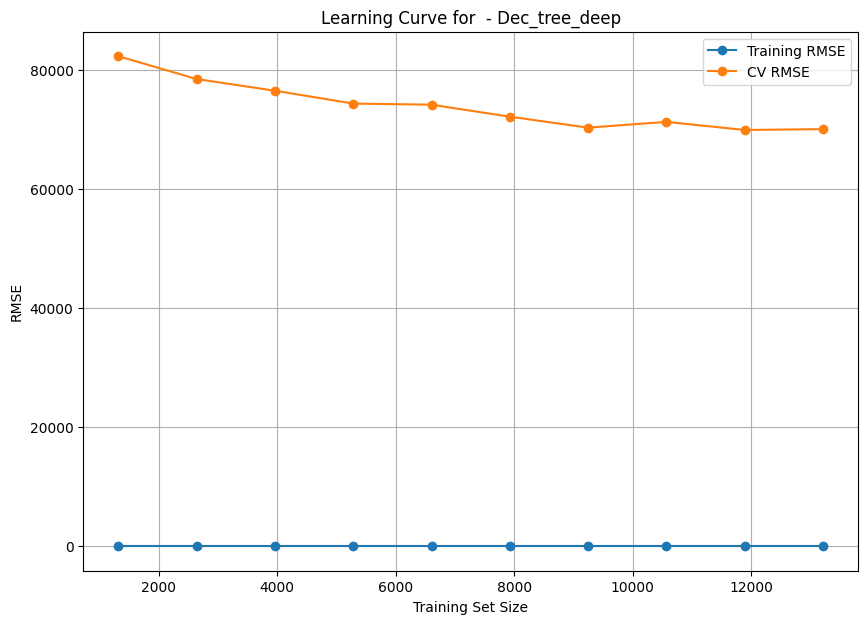

In [49]:
plot_learning_curve(X_train, y_train, tree_dec_deep, 'Dec_tree_deep')